<a href="https://colab.research.google.com/github/pipecode-br/deep_learning_pytorch/blob/main/siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Etapa 1: Importar biblioteca

In [17]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
torch.__version__

'1.10.0+cu111'

In [18]:
torch.manual_seed(123)

### Etapa 2: Construir modelo

In [210]:
import torch
from torch import nn
from torchsummary import summary
import torch.nn.functional as F

class feature(nn.Module):
  def __init__(self) -> None:
      super().__init__()
      # load resnet-18
      resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
      #primeiras camadas conv do resnet
      self.layer1 = nn.Sequential(
          resnet18.conv1,
          resnet18.bn1,
          resnet18.relu,
          resnet18.maxpool
        )
  def forward(self,X):
    X_ = self.layer1(X)
    return X_

class discriminator(nn.Module):
  def __init__(self) -> None:
      super().__init__()
      self.flatten = nn.Flatten()
      size = 115200
      self.dense1 = nn.Linear(in_features=size,out_features=128)
      self.dense2 = nn.Linear(in_features=128,out_features=36)
      self.dense3 = nn.Linear(in_features=36,out_features=1)
      self.dropout = nn.Dropout(0.2)

  def forward(self,X1,X2):
    X1_ = self.flatten(X1)
    X2_ = self.flatten(X2)
    print('pos flatten',X1.shape,X1_.shape)
    # X1 = X1.view(X1.size()[0], -1)
    # X2 = X2.view(X2.size()[0], -1)
    x = torch.cat((X1_,X2_), 1)
    x = self.dropout(F.leaky_relu(self.dense1(x),0.2))    
    x = self.dropout(F.leaky_relu(self.dense2(x),0.2))
    x = self.dropout(F.leaky_relu(self.dense3(x),0.2))
    return x

class siamese(nn.Module):
      def __init__(self) -> None:
          super().__init__()
          self.feature = feature()
          self.discriminator = discriminator()

      def forward(self, X1, X2):          
          X1_ = self.feature(X1)
          X2_ = self.feature(X2)
          X = self.discriminator(X1_, X2_)
          return X

In [235]:
from abc import ABC, abstractmethod

class DeepNeuralInterface(ABC,nn.Module):
    @abstractmethod
    def show(self):
      pass
    @abstractmethod
    def get_transforms(self):
      pass
      
class TrainSiameseInterface(ABC):
    @abstractmethod
    def train(self,net:nn.Module,X,X_real,X_false)->None:
      pass

class teste(TrainSiameseInterface):
  def __init__(self,device) -> None:
      super().__init__()
      self.device = device

  def train(self,net,X,X_real,X_false)->None:
    
    optimizer = optim.Adam(net.parameters(),lr=0.002)
    criterion = nn.BCEWithLogitsLoss()
    print(device)
    net.to(device)
    for i,(imagens_reais,_) in enumerate(X):

      batch_size= imagens_reais.size(0)
      imagens_reais = imagens_reais * 2-1       
      imagens_reais = imagens_reais.to(self.device)

      #treinamento com reais
      outputs_reais = net.forward(imagens_reais,imagens_reais)
      labels_reais = (torch.ones(batch_size)*0.9).to(device)
      D_loss_reais = criterion(outputs_reais.view(*labels_reais.shape),labels_reais)      

      #treinamento com falso
      ruidos = np.random.uniform(low=-1.,high=1.,size=imagens_reais.shape).astype('f')#imagem alearotia fixando em float
      imagens_ruido = torch.from_numpy(ruidos).to(device=self.device)      
      outputs_falsos = net.forward(imagens_reais,imagens_ruido)
      labels_falsos= torch.zeros(batch_size).to(device)
      D_loss_falsos = criterion(outputs_reais.view(*labels_falsos.shape),labels_falsos)

      D_loss = D_loss_reais+ D_loss_falsos
      D_loss.backward()
      optimizer.step()
      print('train ',i,imagens_reais.shape,D_loss_reais,D_loss_falsos)




In [179]:
#criar transformador
#transform = transforms.ToTensor()
preprocess = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(120),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


#baixar base de dados
# train = datasets.MNIST(root='.',train=True,download=True,transform=preprocess)
# test = datasets.MNIST(root='.',train=False,download=True,transform=preprocess)
train = datasets.FakeData(transform=preprocess)

# criar loader
train_loader = torch.utils.data.DataLoader(train,batch_size=64)

## Criação dos objetos

In [211]:
net = siamese()
param = net.parameters()
optimizer = optim.Adam(param,lr=0.002)
criterion = nn.BCEWithLogitsLoss()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [204]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')

In [236]:
teste(device=device).train(net=net,X_real=1,X_false=1,X=train_loader)

cuda
pos flatten torch.Size([64, 64, 30, 30]) torch.Size([64, 57600])
pos flatten torch.Size([64, 64, 30, 30]) torch.Size([64, 57600])
train  0 torch.Size([64, 3, 120, 120]) tensor(0.7077, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.6754, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
pos flatten torch.Size([64, 64, 30, 30]) torch.Size([64, 57600])
pos flatten torch.Size([64, 64, 30, 30]) torch.Size([64, 57600])
train  1 torch.Size([64, 3, 120, 120]) tensor(24.4203, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.1408, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
pos flatten torch.Size([64, 64, 30, 30]) torch.Size([64, 57600])
pos flatten torch.Size([64, 64, 30, 30]) torch.Size([64, 57600])
train  2 torch.Size([64, 3, 120, 120]) tensor(2.4529, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(1.3034, device='cuda:0',
       grad_fn=

In [22]:
img1 =(3 , 40, 40)
summary(net,[img1,img1])

torch.Size([2, 3, 40, 40]) torch.Size([2, 3, 40, 40])
pos flatten torch.Size([2, 6400])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 20, 20]           9,408
       BatchNorm2d-2           [-1, 64, 20, 20]             128
              ReLU-3           [-1, 64, 20, 20]               0
         MaxPool2d-4           [-1, 64, 10, 10]               0
           feature-5           [-1, 64, 10, 10]               0
            Conv2d-6           [-1, 64, 20, 20]           9,408
       BatchNorm2d-7           [-1, 64, 20, 20]             128
              ReLU-8           [-1, 64, 20, 20]               0
         MaxPool2d-9           [-1, 64, 10, 10]               0
          feature-10           [-1, 64, 10, 10]               0
          Flatten-11                 [-1, 6400]               0
          Flatten-12                 [-1, 6400]               0
           Line

### Separa primeiras camadas

## Testa sub modelo em um exemplo real

In [23]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [24]:
# sample execution (requires torchvision)
from PIL import Image
import numpy as np
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(120),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [25]:
model1 = feature()
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model1.to('cuda')

with torch.no_grad():
    output = model1(input_batch)
    out1=output.cpu().numpy()
print(out1.shape)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


(1, 64, 30, 30)


### concatena features da camada de saida

In [26]:
type(out1)
conv_unif = np.sum(out1[0],axis=0)/out1[0].shape[0]

### visualiza resultado

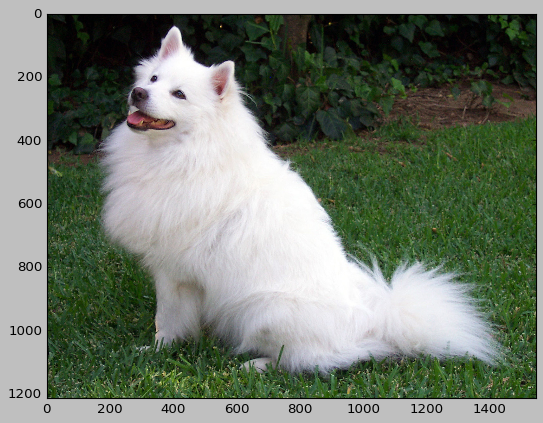

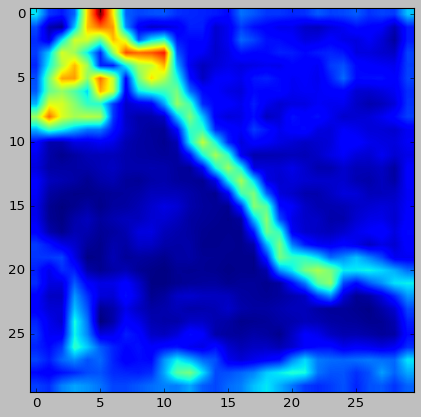

In [27]:
import matplotlib.pyplot as plt
plt.style.use('classic')

plt.imshow(input_image)
plt.show()
plt.imshow(conv_unif)
plt.show()


## Treinando discriminador

In [28]:
num_epoch = 10
for epoch in range(num_epoch):
  D_running_loss = 0
  G_running_loss = 0
  for i,(imagens_reais,_) in enumarate(train_loader):
    batch_size = imagens_reais.size(0)
    # imagens anchoras
    # imagens positiva
    # imagens negativas

NameError: ignored

## Recuperando fibras

In [ ]:
!pip install roboflow
!pip install pylabel

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="JhqX7HlUL57cmzbBqIav")
project = rf.workspace().project("fibberpaper")
dataset = project.version(1).download("yolov5")

In [ ]:
import torch
from torchvision import transforms
import numpy as np
import pandas as pd
from skimage import io
from skimage.transform import resize
from skimage.draw import rectangle

#extrar o conjunto de pixel das fibras contidas no boundbox descrito no dataframe
def extractFibersOfImagens(df):
  mapa = {}
  fibers = []
  #para cada linha 
  for index, row in df.iterrows():
    if "idoc" in row.img_filename: 
      continue
    #ler a imagem e salva no map
    path_full='{}/{}'.format(row.img_folder,row.img_filename)
    if mapa.get(row.img_filename) is None:
      img = io.imread(path_full)
      mapa[row.img_filename]=img
    #recorta o box da fibra
    x1,y1,x2,y2 = int(row.ann_bbox_xmin),int(row.ann_bbox_ymin),int(row.ann_bbox_xmax),int(row.ann_bbox_ymax)
    fibers.append(mapa[row.img_filename][y1:y2,x1:x2])
    #normaliza a imagem com o transforms
    #tenta remover o fundo
  return mapa,fibers

In [ ]:
dataset

In [ ]:
from pylabel import importer
dataset = importer.ImportYoloV5(path='/content/FibberPaper-1/test/labels', path_to_images='/content/FibberPaper-1/test/images')
mapa,fibras = extractFibersOfImagens(dataset.df)


In [ ]:
len(fibras)
plt.imshow(fibras[10])